In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
wells=pd.read_csv('../data/filtered_2.csv')

In [3]:
wells.shape

(16685, 103)

In [4]:
wells_filtered = wells[wells["Vintage"] > 2009]
wells_filtered['ENVProdWellType']= wells_filtered['ENVProdWellType'].replace({'LIQUIDS RICH GAS (10-40% WH LIQUIDS)': 'CONDENSATE',
                                                           'OIL (40%+ WH LIQUIDS)': 'OIL',
                                                           'DRY GAS (0-1% WH LIQUIDS)':'DRY GAS',
                                                           'WET GAS (1-10% WH LIQUIDS)':'WET GAS'})

X = wells_filtered[['ENVProdWellType','ENVInterval','ENVSpacingAssumption','Latitude','Longitude','TVD_FT','Vintage','LateralLength_FT','ProppantIntensity_LBSPerFT','FluidIntensity_BBLPerFT',
           'ParentChildSameZone','WellDensitySameZone','WellsPerSectionSameZone','GasShrink_PCT','NGLYield_BBLPerMMCF','GenericDrainage_AC','Payzone_FT','GammaRay_API',
           'BulkDensity_GPerCC','Resistivity_OHMSM', 'DensityPorosity_PCT','EffectivePorosity_PCT', 'ClayVolume_PCT', 'NonClayVolume_PCT', 'WaterSaturation_PCT', 'PhiH_FT',
           'HCPV_PCT', 'HeightOfHCPV_FT', 'TotalOrganicCarbon_WTPCT'
           ]]
y = wells_filtered[['EURWH_MBOE','OilEURWH_MBBL','GasEURWH_BCF']]

In [ ]:
print(X.shape)
print(y.shape)

(16505, 29)
(16505, 3)


In [ ]:
print("Number of observations with null values:", X.isnull().any(axis = 1).sum())
print("Null values per column:\n", X.isnull().sum(axis = 0))

too_sparse = ['ENVSpacingAssumption', 'WellDensitySameZone', 'ProppantIntensity_LBSPerFT', 'FluidIntensity_BBLPerFT',
           'GasShrink_PCT','NGLYield_BBLPerMMCF','GenericDrainage_AC']

Number of observations with null values: 5854
Null values per column:
 ENVProdWellType                  0
ENVInterval                    112
ENVSpacingAssumption          3908
Latitude                         0
Longitude                        0
TVD_FT                          80
Vintage                          0
LateralLength_FT                14
ProppantIntensity_LBSPerFT    1544
FluidIntensity_BBLPerFT       1463
ParentChildSameZone            130
WellDensitySameZone           3908
WellsPerSectionSameZone        130
GasShrink_PCT                 1016
NGLYield_BBLPerMMCF           1016
GenericDrainage_AC            1018
Payzone_FT                     110
GammaRay_API                   110
BulkDensity_GPerCC             110
Resistivity_OHMSM              110
DensityPorosity_PCT            110
EffectivePorosity_PCT          110
ClayVolume_PCT                 110
NonClayVolume_PCT              110
WaterSaturation_PCT            110
PhiH_FT                        110
HCPV_PCT           

In [ ]:
X_filtered = X.drop(columns = too_sparse)
X_filtered.shape
print("Number of observations with null values:", X_filtered.isnull().any(axis = 1).sum())
print("Null values per column:\n", X_filtered.isnull().sum(axis = 0))
X_filtered = X_filtered.dropna(axis = 0)
print(X_filtered.shape)
y_filtered = y.loc[X_filtered.index]
print(y_filtered.shape)

Number of observations with null values: 217
Null values per column:
 ENVProdWellType               0
ENVInterval                 112
Latitude                      0
Longitude                     0
TVD_FT                       80
Vintage                       0
LateralLength_FT             14
ParentChildSameZone         130
WellsPerSectionSameZone     130
Payzone_FT                  110
GammaRay_API                110
BulkDensity_GPerCC          110
Resistivity_OHMSM           110
DensityPorosity_PCT         110
EffectivePorosity_PCT       110
ClayVolume_PCT              110
NonClayVolume_PCT           110
WaterSaturation_PCT         110
PhiH_FT                     110
HCPV_PCT                    110
HeightOfHCPV_FT             110
TotalOrganicCarbon_WTPCT    110
dtype: int64
(16288, 22)
(16288, 3)


In [ ]:
print(X_filtered['ENVProdWellType'].unique())
print(X_filtered['ENVInterval'].unique())
print(X_filtered['ParentChildSameZone'].unique())

categorical = ['ENVProdWellType','ENVInterval','ParentChildSameZone']
numerical = ['ENVSpacingAssumption','Latitude','Longitude','TVD_FT','Vintage','LateralLength_FT','ProppantIntensity_LBSPerFT','FluidIntensity_BBLPerFT',
           'WellDensitySameZone','WellsPerSectionSameZone','GasShrink_PCT','NGLYield_BBLPerMMCF','GenericDrainage_AC','Payzone_FT','GammaRay_API',
           'BulkDensity_GPerCC','Resistivity_OHMSM', 'DensityPorosity_PCT','EffectivePorosity_PCT', 'ClayVolume_PCT', 'NonClayVolume_PCT', 'WaterSaturation_PCT', 'PhiH_FT',
           'HCPV_PCT', 'HeightOfHCPV_FT', 'TotalOrganicCarbon_WTPCT']

for feat in categorical:
  one_hot = pd.get_dummies(X_filtered[feat])
  X_filtered = X_filtered.drop(feat, axis = 1)
  X_filtered = X_filtered.join(one_hot)

print(X_filtered.shape)
print(X_filtered.columns)

['CONDENSATE' 'OIL' 'DRY GAS' 'WET GAS']
['WOLFCAMP A LOWER' '3RD BONE SPRING SAND' 'WOLFCAMP A UPPER'
 '2ND BONE SPRING SAND' 'LOWER AVALON' 'WOLFCAMP B UPPER'
 'WOLFCAMP B LOWER' '3RD BONE SPRING' 'WOLFCAMP D' 'MIDDLE AVALON'
 'WOLFCAMP C' '1ST BONE SPRING' 'UPPER AVALON' '2ND BONE SPRING']
['CO-COMPLETED' 'CHILD' 'STANDALONE' 'PARENT']
(16288, 41)
Index(['Latitude', 'Longitude', 'TVD_FT', 'Vintage', 'LateralLength_FT',
       'WellsPerSectionSameZone', 'Payzone_FT', 'GammaRay_API',
       'BulkDensity_GPerCC', 'Resistivity_OHMSM', 'DensityPorosity_PCT',
       'EffectivePorosity_PCT', 'ClayVolume_PCT', 'NonClayVolume_PCT',
       'WaterSaturation_PCT', 'PhiH_FT', 'HCPV_PCT', 'HeightOfHCPV_FT',
       'TotalOrganicCarbon_WTPCT', 'CONDENSATE', 'DRY GAS', 'OIL', 'WET GAS',
       '1ST BONE SPRING', '2ND BONE SPRING', '2ND BONE SPRING SAND',
       '3RD BONE SPRING', '3RD BONE SPRING SAND', 'LOWER AVALON',
       'MIDDLE AVALON', 'UPPER AVALON', 'WOLFCAMP A LOWER', 'WOLFCAMP A UPPER',
 

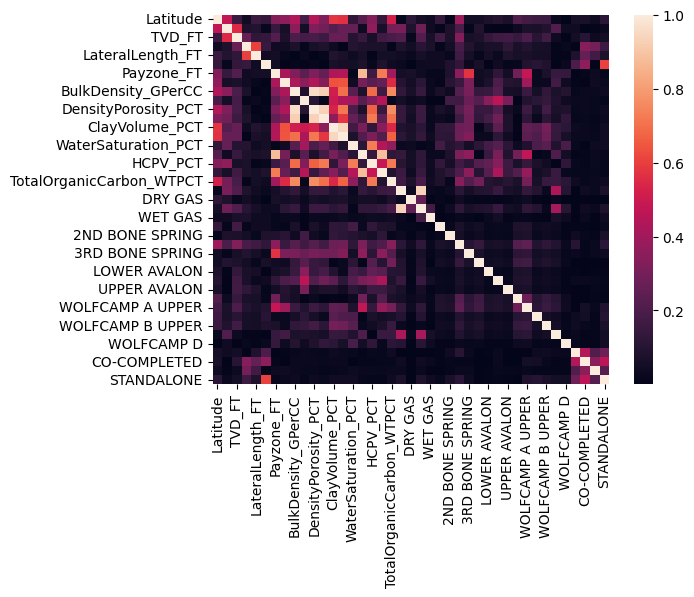

In [ ]:
correlation = X_filtered.corr().abs()
sns.heatmap(correlation)
correlation = np.triu(correlation, 1)

In [ ]:
!pip install umap-learn
import umap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=791ab7f6872c4f26073ea762b74f66ecab7a1a0235735bb3dd4fec4fef7373dc
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=20a23a718c7b4ba4266f342bc6ef115cee6560651e31873ead5f0949d473a316
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size = 0.2)

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("RMSE:\n", np.sqrt(((y_test - pred) ** 2).mean()))
print()
print("NRMSE:\n", np.sqrt(((y_test - pred) ** 2).mean()) / y_test.mean(axis = 0))

RMSE:
 EURWH_MBOE       541.578673
OilEURWH_MBBL    336.264804
GasEURWH_BCF       1.867175
dtype: float64

NRMSE:
 EURWH_MBOE       0.509715
OilEURWH_MBBL    0.577492
GasEURWH_BCF     0.647872
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("RMSE:\n", np.sqrt(((y_test - pred) ** 2).mean()))
print()
print("NRMSE:\n", np.sqrt(((y_test - pred) ** 2).mean()) / y_test.mean(axis = 0))

RMSE:
 EURWH_MBOE       484.885435
OilEURWH_MBBL    314.582822
GasEURWH_BCF       1.531852
dtype: float64

NRMSE:
 EURWH_MBOE       0.456358
OilEURWH_MBBL    0.540256
GasEURWH_BCF     0.531521
dtype: float64


In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(SVR())
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("RMSE:\n", np.sqrt(((y_test - pred) ** 2).mean()))
print()
print("NRMSE:\n", np.sqrt(((y_test - pred) ** 2).mean()) / y_test.mean(axis = 0))

RMSE:
 EURWH_MBOE       622.282209
OilEURWH_MBBL    366.145522
GasEURWH_BCF       2.520796
dtype: float64

NRMSE:
 EURWH_MBOE       0.585671
OilEURWH_MBBL    0.628809
GasEURWH_BCF     0.874665
dtype: float64


In [ ]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("RMSE:\n", np.sqrt(((y_test - pred) ** 2).mean()))
print()
print("NRMSE:\n", np.sqrt(((y_test - pred) ** 2).mean()) / y_test.mean(axis = 0))

RMSE:
 EURWH_MBOE       580.888504
OilEURWH_MBBL    360.925965
GasEURWH_BCF      13.998242
dtype: float64

NRMSE:
 EURWH_MBOE       0.546712
OilEURWH_MBBL    0.619845
GasEURWH_BCF     4.857105
dtype: float64


In [ ]:
# https://geographicdata.science/book/notebooks/11_regression.html#bringing-space-into-the-regression-framework